# Homework \#2
**Student: Alex Smith** <br>
Course: W261 - Machine Learning at Scale <br>
Professor: Jimi Shanahan <br>
Due Date: May 27

***
### Useful resources
When completing this notebook, I found the following resources particularly useful:
- [Race conditions, mutual exclusion, synchronization, and parallel slowdown](https://en.wikipedia.org/wiki/Parallel_computing#Race_conditions.2C_mutual_exclusion.2C_synchronization.2C_and_parallel_slowdown)
- [Data-Intensive Text Processing with MapReduce](https://lintool.github.io/MapReduceAlgorithms/)

### Libraries
The following libraries must be installed before running the below code. They can all be installed through [Pip](https://github.com/pypa/pip).
- [Scikit Learn](http://scikit-learn.org/stable/)
- [Numpy](http://www.numpy.org/)
- [Regular Expression](https://docs.python.org/2/library/re.html)
- [Pretty Table](https://pypi.python.org/pypi/PrettyTable)
- [Random](https://docs.python.org/2/library/random.html)

***
### Environment: Cloudera
This notebook is designed to run in a Cloudera virtual box. To set up a virtual box like this one, follow the instructions [here](https://docs.google.com/presentation/d/1qCQM-2U2C6e584uM9kqTGr675K3_a8M1mEZaiT4Wmi8/edit#slide=id.p). Before beginning, make sure that you have started (in the following order) from the Cloudera manager:
1. Zookeeper
1. Yarn
1. HDFS

In [95]:
# we create some generic folders to make running
# the hadoop commands simpler
# you should have already made the w261 directory
# when you followed the cloudera installation
# instructions
!mkdir ~/w261/Outputs
!mkdir ~/w261/data
!hdfs dfs -mkdir -p /user/cloudera/w261

***
### HW2.0.  
*What is a race condition in the context of parallel computation? Give an example. <br>
What is MapReduce? <br>
How does it differ from Hadoop?*

In the context of parallel computation, the **race condition** is when two parallel processes attempt to access and update some variable. If the sequence of access and update can change the variable outcome, we have a potential race condition. Let's consider an example inspired by Async 2.4. We have two parallel programs, A and B.
- Program A: 
    - Read variable V
    - Assign to V: V • 2    
- Program B:
    - Read variable V
    - Assign to V: V • V

We have different conditions based on the sequence of events:
- Case 1: Both programs could read V at the same time, Program A updates V last
    - Both programs could read V at the same time
    - Program B updates V to V<sup>2</sup>
    - Program A updates V to 2V
    - **Final result: 2V**
- Case 2: Both programs could read V at the same time, Program B updates V last 
    - Both programs could read V at the same time
    - Program A updates V to 2V
    - Program B updates V to V<sup>2</sup>
    - **Final result: V<sup>2</sup>**
- Case 3: Program A reads V first, then Program B
    - Program A updates V to 2V
    - Program B reads the updated value of V
    - Program B updates V to V<sup>2</sup>
    - **Final result: 4V<sup>2</sup>**
- Case 4: Program B reads V first, then Program A
    - Program B updates V to V<sup>2</sup>
    - Program A reads the updated value of V
    - Program A updates V to 2V
    - **Final result: 2V<sup>2</sup>**

**MapReduce** is a framework that allows for parallelization of computation across many nodes. It is an abstraction that handles most of the details of the parallelization behind the scenes while allowing the programmer to focus on writing parallel computations. One of the major advantages of MapReduce is that it moves the code to the data rather than the data to the code. This is helpful because moving data to code is time intensive and risky. MapReduce is designed to handle large data sets and distribute the computation over them. The name "MapReduce" comes from the mappers and reducers that make up the programming. We can think of the mapper by comparing it to the mapper in *functional programming* that applies a function to every value of its input. We can think of the reducer by comparing it othe fold function in functional programming that combines the results of multiple outputs from the mappers. **Hadoop** is a specific open source implementation of MapReduce. It differs slightly from other implementations of MapReduce, such as Google's proprietary implementation. In addition to a MapReduce framework, Hadoop also includes a distributed file system for holding large amounts of data. Hadoop is based on the **functional programming paradigm** of MapReduce. It is built on top of Java, a non-functional programming language.

### HW2.0.1  
*Which programming paradigm is Hadoop based on? Explain and give a simple example of functional programming in raw python code and show the code running. E.g., in raw python find the average length of a string in and of strings using a python "map-reduce" (functional programming) job (similar in style to the above). Alternatively, you can do this in python Hadoop Streaming.<br>
strings = ["str1", "string2", "w261", "MAchine learning at SCALE"]*<br>
**We answer this last part of the question in the last paragraph of the part above because it flows with that information.**

In [49]:
# import our libraries for functional programming
import functools

# set our strings
strings = \
["str1","string2","w261","MAchine learning at SCALE"]

# add a length of zero to front of the string
strings.insert(0,0)

# calculate the average
average = \
functools.reduce(lambda x,y:x+len(y),strings)/len(strings)

print "The average length of the strings is",average

The average length of the strings is 8


***
### HW2.1. Sort in Hadoop MapReduce
*Given as input: Records of the form (integer, “NA”), where integer is any integer, and “NA” is just the empty string.
<br>Output: sorted key value pairs of the form (integer, “NA”) in decreasing order.
<br>What happens if you have multiple reducers? Do you need additional steps? Explain.<br>
Write code to generate N  random records of the form (integer, “NA”). Let N = 10,000.
Write the python Hadoop streaming map-reduce job to perform this sort. Display the top 10 biggest numbers. Display the 10 smallest numbers*

##### Multiple reducers
If we have multiple reducers, we need to make sure that we sort the inputs before they enter the reducers. Each reducer should get all the mapper outputs for a given key. This ensures that the operations done on a given key are complete by the time of the reducer's output. If we're sorting the outputs from all the reducers, we might need a final reducer to complete that sort.

##### Generate 10,000 random numbers
We write a program to generate 10,000 random integers between 1 and 10,000. 

In [3]:
# import the library random to help us generate
# the random numbers
import random

def generateN(N=10000,lower=1,upper=10000,
             filename="data/random_input.txt"):
    """generate N random integers between
    the upper and lower limits and print
    these numbers out to a file in the form:
    integer <tab> empty string <new line>"""
    
    # create a new file 
    with open(filename,"w") as myfile:
        
        # create a new line for each random
        # integer specified
        for n in range(N):
            
            # get the line we are writing
            info = str(random.randint(lower,upper)) + \
            "\t" + "" + "\n"
            
            # write the information to the file
            myfile.write(info)

In [4]:
# create the file of random integers
generateN()

##### Mapper
We write a mapper function to take as input a file with a list of integers and sort it from smallest to largest and output to another file. 

In [1]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Alex Smith
## Description: mapper code for HW2.1

# import our libraries to use regular expression and 
# read from the system arguments
import sys
import re

# create a list and read each line into it
numbers = []

# loop through each line
for line in sys.stdin:

    # split off any extra spaces
    number = line.strip()

    # add the number to the list as an
    # integer
    numbers.append(int(number))

# loop through each number and print it out
# for number in numbers_nodupes:
for number in sorted(numbers):
    print number

Overwriting mapper.py


##### Test the mapper on the command-line

In [9]:
!chmod +x mapper.py
!cat data/random_input.txt | ~/w261/mapper.py  > testingM.txt
!head testingM.txt

5
6
8
9
9
11
14
15
16
18


##### Reducer function
We write a reducer function that takes the outputs from the multiple mapper functions and sorts each list by comparing the first elements from each list. Our reducer function does not have to do much work because Hadoop already sorts the outputs from the mappers.

In [5]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Alex Smith
## Description: reducer code for HW2.1

# import our libraries to use regular expression and 
# read from the system arguments
import sys
import re

# create an array to hold all the numbers
numbers = []

# loop through each number and append it to
# the list
for line in sys.stdin:
    
    # strip away random line breaks
    number = line.strip()
    
    # append the number to our list of numbers
    numbers.append(int(number))

# print out the sorted list as our output
for number in numbers:
    print number

Overwriting reducer.py


##### Testing our reducer on the commandline

In [10]:
!chmod +x reducer.py
!cat testingM.txt | ~/w261/reducer.py  > testingR.txt
!head testingR.txt

5
6
8
9
9
11
14
15
16
18


##### Command line code to run our program in Hadoop

In [7]:
# first let's clear our input directory to make
# sure that we're starting off with a clean slate
!hdfs dfs -rm -r /user/cloudera/w261/*

# modifies the permission to make the programs
# executable
!chmod +x ~/w261/mapper.py; chmod +x ~/w261/reducer.py

# put the input data into the hadoop cluster
!hdfs dfs -copyFromLocal /home/cloudera/w261/data/random_input.txt /user/cloudera/w261/

# make sure that we don't already have this output
!hdfs dfs -rm -r /user/cloudera/w261-output-2-1
!rm -r /home/cloudera/w261/Outputs/Out_2_1

# run the hadoop command
!hadoop jar /usr/lib/hadoop-0.20-mapreduce/contrib/streaming/hadoop-streaming-mr1.jar \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D  mapred.text.key.comparator.options=-n \
-file /home/cloudera/w261/mapper.py    -mapper /home/cloudera/w261/mapper.py \
-file /home/cloudera/w261/reducer.py   -reducer /home/cloudera/w261/reducer.py \
-input /user/cloudera/w261/* -output /user/cloudera/w261-output-2-1

# copy the output file to the local directory
!hdfs dfs -copyToLocal /user/cloudera/w261-output-2-1/part-00000 /home/cloudera/w261/Outputs/

# rename the file
!mv /home/cloudera/w261/Outputs/part-00000 /home/cloudera/w261/Outputs/Out_2_1

16/05/25 19:36:18 INFO fs.TrashPolicyDefault: Moved: 'hdfs://quickstart.cloudera:8020/user/cloudera/w261/random_input.txt' to trash at: hdfs://quickstart.cloudera:8020/user/cloudera/.Trash/Current/user/cloudera/w261/random_input.txt1464230178920
16/05/25 19:36:29 INFO fs.TrashPolicyDefault: Moved: 'hdfs://quickstart.cloudera:8020/user/cloudera/w261-output-2-1' to trash at: hdfs://quickstart.cloudera:8020/user/cloudera/.Trash/Current/user/cloudera/w261-output-2-11464230189333
16/05/25 19:36:30 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/home/cloudera/w261/mapper.py, /home/cloudera/w261/reducer.py] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob896569251327698838.jar tmpDir=null
16/05/25 19:36:33 INFO client.RMProxy: Connecting to ResourceManager at quickstart.cloudera/10.0.2.15:8032
16/05/25 19:36:33 INFO client.RMProxy: Connecting to ResourceManager at quickstart.cloudera/10.0.2.15:8032
16/05/25 19:36:3

##### Display the highest and lowest numbers

In [8]:
# set a list to hold our numbers
numbers = []

# open the file as readable
with open("Outputs/Out_2_1","r") as myfile:
    
    # read in all the lines and loop through them
    for line in myfile.readlines():
        
        # add each line to the list
        numbers.append(int(line))
    
# print out the highest and lowest ten numbers
print "The highest ten numbers are:", numbers[-10:]
print "The lowest ten numbers are:", numbers[0:10]

The highest ten numbers are: [9991, 9991, 9992, 9996, 9996, 9997, 9998, 9999, 9999, 10000]
The lowest ten numbers are: [1, 2, 3, 3, 3, 3, 4, 6, 7, 7]


***
### HW2.2.  WORDCOUNT
*Using the Enron data from HW1 and Hadoop MapReduce streaming, write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count results.
<br>CROSSCHECK: >grep assistance enronemail_1h.txt|cut -d$'\t' -f4| grep assistance|wc -l
<br>8
<br>#NOTE  "assistance" occurs on 8 lines but how many times does the token occur? 10 times! This is the number we are looking for!*

##### Mapper function
We write a mapper function that takes a chunk of text and outputs a tab delimited list with each word and its associated count.

In [11]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Alex Smith
## Description: mapper code for HW2.2

# import our libraries to use regular expression and 
# read from the system arguments; initalize the count
import sys
import re
count = 0

# create a regex that matches alphanumeric characters
wordify = re.compile(r"[\w']+")

# create a dictionary that stores the word and its
# associated count
wordcounts = {}
    
# loop through each line in the file
for line in sys.stdin:

    # convert the line into a list of words without punctuation
    # also lowercase all the words
    words = wordify.findall(line.lower())

    # loop through each word in each line
    for word in words:

        # if the word is not in the dictionary, 
        # initalize the dictionary entry with a 
        # count of zero
        if word not in wordcounts.keys():
            wordcounts[word] = 1

        # otherwise, incremement the count by 1
        else:
            wordcounts[word] = wordcounts[word]+1

# loop through each word and its associated word count
# print it out to the system
for word in wordcounts.keys():
    print word,"\t",wordcounts[word]

Overwriting mapper.py


##### Test the mapper in the command line

In [12]:
# set the permissions and execute
!chmod +x mapper.py
!cat data/enronemail_1h.txt | ~/w261/mapper.py > testingM.txt
!head testingM.txt

yellow 	1
four 	8
prefix 	1
railing 	1
looking 	4
granting 	1
electricity 	1
originality 	1
homemakers 	1
hormone 	2


##### Reducer function
The reducer function takes the outputs from the many mappers and combines them to find the word count for each word. 

In [34]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Alex Smith
## Description: reducer code for HW2.2

# import the system libraries to read from the input
import sys

# initalize a dictionary to hold each word and
# its associated count
wordcounts = {}

# loop through each line in the input
for line in sys.stdin:

    line = line.split("\t")
    word = line[0].strip()
    count = int(line[1])
    
    # if the word is not in the dictionary, 
    # initalize the dictionary entry
    if word not in wordcounts.keys():
        wordcounts[word] = count

    # otherwise, incremement add to the count
    else:
        wordcounts[word] = wordcounts[word]+count
    
# loop through each word in the dictionary and 
# print the word with its count
for word in wordcounts.keys():
    print word,"\t",wordcounts[word]

Overwriting reducer.py


##### Test the reducer on the command line

In [35]:
# set permissions and execute
!chmod +x reducer.py
!cat testingM.txt | ~/w261/reducer.py > testingR.txt
!head testingR.txt

yellow 	1
four 	8
prefix 	1
railing 	1
looking 	4
granting 	1
electricity 	1
originality 	1
homemakers 	1
hormone 	2


##### Set the right permissions and execute the code

In [11]:
# first let's clear our input directory to make
# sure that we're starting off with a clean slate
!hdfs dfs -rm -r /user/cloudera/w261/*

# modifies the permission to make the programs
# executable
!chmod +x ~/w261/mapper.py; chmod +x ~/w261/reducer.py

# put the input data into the hadoop cluster
!hdfs dfs -copyFromLocal /home/cloudera/w261/data/enronemail_1h.txt /user/cloudera/w261/

# make sure that we don't already have this output
!hdfs dfs -rm -r /user/cloudera/w261-output-2-2
!rm -r /home/cloudera/w261/Outputs/Out_2_2

# run the hadoop command
!hadoop jar /usr/lib/hadoop-0.20-mapreduce/contrib/streaming/hadoop-streaming-mr1.jar \
-file /home/cloudera/w261/mapper.py    -mapper /home/cloudera/w261/mapper.py \
-file /home/cloudera/w261/reducer.py   -reducer /home/cloudera/w261/reducer.py \
-input /user/cloudera/w261/* -output /user/cloudera/w261-output-2-2

# copy the output file to the local directory
!hdfs dfs -copyToLocal /user/cloudera/w261-output-2-2/part-00000 /home/cloudera/w261/Outputs/

# rename the file
!mv /home/cloudera/w261/Outputs/part-00000 /home/cloudera/w261/Outputs/Out_2_2

16/05/25 19:53:40 INFO fs.TrashPolicyDefault: Moved: 'hdfs://quickstart.cloudera:8020/user/cloudera/w261/random_input.txt' to trash at: hdfs://quickstart.cloudera:8020/user/cloudera/.Trash/Current/user/cloudera/w261/random_input.txt1464231220472
rm: `/user/cloudera/w261-output-2-2': No such file or directory
16/05/25 19:53:49 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/home/cloudera/w261/mapper.py, /home/cloudera/w261/reducer.py] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob2359727465864169885.jar tmpDir=null
16/05/25 19:53:51 INFO client.RMProxy: Connecting to ResourceManager at quickstart.cloudera/10.0.2.15:8032
16/05/25 19:53:52 INFO client.RMProxy: Connecting to ResourceManager at quickstart.cloudera/10.0.2.15:8032
16/05/25 19:53:53 INFO mapred.FileInputFormat: Total input paths to process : 1
16/05/25 19:53:53 INFO mapreduce.JobSubmitter: number of splits:2
16/05/25 19:53:53 INFO mapreduce.JobSub

##### Check how many times 'assistance' appears

In [12]:
# set the word we're looking for
FIND = 'assistance'

# open the output file
with open('Outputs/Out_2_2', 'r') as myfile:
    
    # loop through each line
    for line in myfile.readlines():
        
        # separate each line by the tab
        line = line.split("\t")
        
        # set the value
        word = line[0].strip()
        count = int(line[1])
        
        # if we've found the word assistance,
        # break out of the loop
        if word == FIND: break

# print out that we found the word and its count
print "The word", word, "appears", count, "times."

The word assistance appears 10 times.


***
### HW2.2.1  
Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)

###### Mapper function
We write a simple mapper function that takes the output of the previous reducer and makes the count the key and the word the value.

In [37]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Alex Smith
## Description: mapper code for HW2.2.1

# import our libraries to use regular expression and 
# read from the system arguments; initalize the count
import sys
    
# loop through each line in the file
for line in sys.stdin:

    # split the line based on the tab
    line = line.split("\t")
    
    # set the new key value pair
    info = str(line[1].strip()) + "\t" + str(line[0].strip())

    # print the new key value pair out
    print info

Overwriting mapper.py


##### Test the mapper on the command line

In [38]:
# set the permissions and execute
!chmod +x mapper.py
!cat Outputs/Out_2_2 | ~/w261/mapper.py > testingM.txt
!head testingM.txt

1	considered
1	screaming
1	sending
2	audio
1	linda's
1	wood
4	advice
7	writing
2	discontinue
1	reclaimers


##### Reducer function
We write a simple reducer function that simply yields the sorted list from the mapper. This is a good reducer to build because then we can use it to test other mappers since it only yields what the mapper gives it.

In [39]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Alex Smith
## Description: reducer code for HW2.2.1

# import the system libraries to read from the input
import sys

# loop through each line in the input and print
# it out
for line in sys.stdin:
    print line.strip()

Overwriting reducer.py


##### Test the reducer on the command line

In [42]:
!chmod +x reducer.py
!cat testingM.txt |sort -k1nr | ~/w261/reducer.py > testingR.txt
!head testingR.txt

1247	the
963	to
668	and
566	of
542	a
432	you
417	in
394	your
382	ect
373	for


##### Make the files executable and run the hadoop

In [28]:
# first let's clear our input directory to make
# sure that we're starting off with a clean slate
!hdfs dfs -rm -r /user/cloudera/w261/*

# modifies the permission to make the programs
# executable
!chmod +x ~/w261/mapper.py; chmod +x ~/w261/reducer.py

# put the input data into the hadoop cluster
!hdfs dfs -copyFromLocal /home/cloudera/w261/Outputs/Out_2_2 /user/cloudera/w261/

# make sure that we don't already have this output
!hdfs dfs -rm -r /user/cloudera/w261-output-2-2-1
!rm -r /home/cloudera/w261/Outputs/Out_2_2_1

# run the hadoop command
!hadoop jar /usr/lib/hadoop-0.20-mapreduce/contrib/streaming/hadoop-streaming-mr1.jar \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D  mapred.text.key.comparator.options=-n \
-file /home/cloudera/w261/mapper.py    -mapper /home/cloudera/w261/mapper.py \
-file /home/cloudera/w261/reducer.py   -reducer /home/cloudera/w261/reducer.py \
-input /user/cloudera/w261/* -output /user/cloudera/w261-output-2-2-1

# copy the output file to the local directory
!hdfs dfs -copyToLocal /user/cloudera/w261-output-2-2-1/part-00000 /home/cloudera/w261/Outputs/

# rename the file
!mv /home/cloudera/w261/Outputs/part-00000 /home/cloudera/w261/Outputs/Out_2_2_1

16/05/26 18:12:51 INFO fs.TrashPolicyDefault: Moved: 'hdfs://quickstart.cloudera:8020/user/cloudera/w261/Out_2_2' to trash at: hdfs://quickstart.cloudera:8020/user/cloudera/.Trash/Current/user/cloudera/w261/Out_2_21464311571945
16/05/26 18:12:59 INFO fs.TrashPolicyDefault: Moved: 'hdfs://quickstart.cloudera:8020/user/cloudera/w261-output-2-2-1' to trash at: hdfs://quickstart.cloudera:8020/user/cloudera/.Trash/Current/user/cloudera/w261-output-2-2-11464311579169
16/05/26 18:13:01 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/home/cloudera/w261/mapper.py, /home/cloudera/w261/reducer.py] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob3428225655655091828.jar tmpDir=null
16/05/26 18:13:04 INFO client.RMProxy: Connecting to ResourceManager at quickstart.cloudera/10.0.2.15:8032
16/05/26 18:13:04 INFO client.RMProxy: Connecting to ResourceManager at quickstart.cloudera/10.0.2.15:8032
16/05/26 18:13:05 INFO mapred

##### Top ten
We create a function to read in the output of the MapReduce and print out the top 10 words.

In [33]:
# create a list to hold the top words
# and the counts for each word
words = []
counts = []

# open the file
with open("Outputs/Out_2_2_1","r") as myfile:
    
    # read the lines and save them to the lists
    for line in myfile.readlines():
        # split the line into a list by tabs
        line = line.split("\t")
        
        # set the words and counts
        word = str(line[1].strip())
        count = int(line[0].strip())
        
        # append the word and counts to our
        # master lists
        words.append(word)
        counts.append(count)

# print the most frequently occuring words
print "The most frequently occuring words are:"
for index,word in enumerate(words[-10:]):
    print "\t" + word + "\t" + str(counts[-index-1])

The most frequently occuring words are:
	for	1247
	ect	963
	your	668
	in	566
	you	542
	a	432
	of	417
	and	394
	to	382
	the	373


***
### HW2.3. Multinomial Naive Bayes with no Smoothing
*Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that will both learn  Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). Note: for multinomial Naive Bayes, the Pr(X=“assistance”|Y=SPAM) is calculated as follows:
<br>the number of times “assistance” occurs in SPAM labeled documents / the number of words in documents labeled SPAM 
<br>E.g.,   “assistance” occurs 5 times in all of the documents Labeled SPAM, and the length in terms of the number of words in all documents labeled as SPAM (when concatenated) is 1,000. Then Pr(X=“assistance”|Y=SPAM) = 5/1000. Note this is a multinomial estimation of the class conditional for a Naive Bayes Classifier. No smoothing is needed in this HW. Multiplying lots of probabilities, which are between 0 and 1, can result in floating-point underflow. Since log(xy) = log(x) + log(y), it is better to perform all computations by summing logs of probabilities rather than multiplying probabilities. Please pay attention to probabilites that are zero! They will need special attention. Count up how many times you need to process a zero probabilty for each class and report. 
<br>Report the performance of your learnt classifier in terms of misclassifcation error rate of your multinomial Naive Bayes Classifier. Plot a histogram of the  posterior probabilities (i.e., Pr(Class|Doc)) for each class over the training set. Summarize what you see. 
<br>Error Rate = misclassification rate with respect to a provided set (say training set in this case). It is more formally defined here:
<br>Let DF represent the evalution set in the following:
<br>Err(Model, DF) = |{(X, c(X)) ∈ DF : c(X) != Model(x)}|   / |DF|
<br>Where || denotes set cardinality; c(X) denotes the class of the tuple X in DF; and Model(X) denotes the class inferred by the Model “Model”*

##### Mapper function
The goal of this function is to spit out the occurences for each word. The input will be a chunk of email messages. The output will be a tab delimited file:
- email id
- spam indicator
- word

In [43]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Alex Smith
## Description: mapper code for HW2.3

# import our libraries to use regular expression and 
# read from the system arguments
import sys
import re

# initalize the outputs that we'll be using
email_id = None
word_act = None
spam_ind = None
    
# create a regex that matches alphanumeric characters
wordify = re.compile(r"[\w']+")

# loop through each line in the file
for line in sys.stdin:

    # separate out each line based on the tabs
    line = line.split("\t")
    
    # set the email id and spam indicator fields
    email_id = line[0]
    spam_ind = line[1]

    # grab the text from the body and 
    # subject and concatenate it, if both exist
    if len(line)==4:
        text = line[2] + " " + line[3]
    else:
        text = line[2]

    # convert the text into a list of 
    # words without punctuation
    # also lowercase all the words
    words = wordify.findall(text.lower())
        
    # loop through each word
    for word in words:

        # collect the line that we want to print out
        info = email_id + "\t" + word + "\t" + str(spam_ind)

        # let's print each email id, word, 
        # spam indicator
        # we'll separate each value with a tab character
        print info

Overwriting mapper.py


##### Test the mapper function on the command line

In [44]:
# set the permissions and execute
!chmod +x mapper.py
!cat data/enronemail_1h.txt | ~/w261/mapper.py  > testingM.txt
!head testingM.txt

0001.1999-12-10.farmer	christmas	0
0001.1999-12-10.farmer	tree	0
0001.1999-12-10.farmer	farm	0
0001.1999-12-10.farmer	pictures	0
0001.1999-12-10.farmer	na	0
0001.1999-12-10.kaminski	re	0
0001.1999-12-10.kaminski	rankings	0
0001.1999-12-10.kaminski	thank	0
0001.1999-12-10.kaminski	you	0
0001.2000-01-17.beck	leadership	0


##### Reducer function
This function inputs the outputs from the multiple mapper functions. It uses this information to first develop a Naive Bayes classifier based on each email word. Second, it uses this Naive Bayes classifier to classify each email as spam or not spam. <br>
In addition, it completes a number of other tasks:
- writes a file storing the count of zero probabilities for each class
- writes a file storing the posterior probability, P(spam | words) and P(nspam | words) for each document

The reducer itself will output a tab delimited file with the email id, the true spam indicator, and the spam prediction indicator. 

In [45]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Alex Smith
## Description: reducer code for HW2.3

# import the system libraries to read 
# from the input, from the 
# math library import the log function
import sys
from math import log

# create a dictionary to store each email id, 
# spam indciator, list of words of 
# interest, and spam prediction
emails = {}
    
# initalize the summary statistic counts
all_words = 0
all_emails = 0
spam_emails = 0
spam_ewords = 0 # number of words in spam emails

# let's initalize a dictionary that will 
# hold the probabilities for 
# each and every word in the corpus
words_probs = {}

##
##
## gather summary statistics and words for each email
##
##
        
# loop through each line in the file
for line in sys.stdin:

    # split the line by tabs
    line = line.split("\t")

    # pull out my values for each part of the line
    email_id = line[0]
    word_act = line[1]
    spam_ind = int(line[2])

    # let's update the number of words and 
    # the spam words (if it's spam)
    all_words = all_words + 1
    if spam_ind == 1:
        spam_ewords = spam_ewords + 1

    # if we don't already have the word in 
    # our dictionary of words, let's
    # add it and initalize counts of zero
    if word_act not in words_probs:
        words_probs[word_act] = \
        {"spam_count":0,"not_spam_count":0}

    # let's grab the dictionary for the word
    word_dict = words_probs[word_act]

    # let's increment the word counts 
    # for the word
    if spam_ind == 1:
        word_dict['spam_count'] = \
        word_dict['spam_count'] + 1
    else:
        word_dict['not_spam_count'] = \
        word_dict['not_spam_count'] + 1

    # check to see if this email is already 
    # in the dictionary, and if
    # its not already there, initalize it
    if email_id not in emails:

        # create a sub-dictionary within 
        # the email dictionary for each email
        emails[email_id] = \
        {"spam":spam_ind, "words":[]}

        # if it's not already there, 
        # let's also increment the email counter
        # and the spam counter if it's spam
        all_emails = all_emails + 1
        if spam_ind == 1:
            spam_emails = spam_emails + 1

    # let's add the word to our list 
    # of words for this email
    emails[email_id]["words"].append(word_act)

##
##
## build the naive bayes classifier
##
##

# posterior probabilities
prob_spam = float(spam_emails) / float(all_emails)
prob_nspam = 1.0 - prob_spam

# for each word, let's calculate the 
# conditional probability of spam given the word
# and not spam given the word

# let's define our LaPlace smoother 
# (in this case, 0)
SMOOTHER = 0
VOCAB = 0

# look at each word
for word in words_probs.keys():
    
    # set the find word that we'll be 
    # calculating the probabilities for
    word = words_probs[word]
    
    # calculate the probability of the word
    word['total'] = word['spam_count'] + \
    word['not_spam_count']
    word['probs'] = float(word['total']) / \
    float(all_words)
    
    # calculate the probability of word 
    # given spam and add the smoother
    word['wordGIVspam'] = \
    float(word['spam_count'] + SMOOTHER) / \
    float(spam_ewords + VOCAB)
    
    # calculate the probability of the word 
    # given not spam and add the smoother
    word['wordGIVnspam'] = \
    float(word['not_spam_count'] + SMOOTHER) / \
    float(all_words-spam_ewords + VOCAB)

# now let's print our model out to the file
# this will be useful because it will make it
# easier to load it in future functions

# set the header
print "Word \tCount \tP(word|Spam) \tP(word|Not Spam)"

# loop through each word
for word in words_probs.keys():

    # set the word name
    word_name = word

    # set the word that we'll be 
    # printing the probabilities for
    word = words_probs[word]

    # set each line as tab delimited
    info = str(word_name) + "\t" +\
    str(word['total']) + "\t" +\
    str(word['wordGIVspam']) + "\t" +\
    str(word['wordGIVnspam'])

    # print each line
    print info   

# print a separating line to split each section
print "*~*~*~*~*"

##
##
## use the classifier to classify each email
##
##      

# initalizate variables to store the counts of zero
# posterior probabilities for each class
spam_zeros = 0
nspam_zeros = 0

# create a dictionary that will store the posterior
# probabilities for each email
email_probs = {}

# now let's loop through each email in 
# the dictionary 
for email in emails.keys():
    
    # get the actual classification
    truth = emails[email]["spam"]
    
    # if the email has no words, then set the 
    # prediction based on the posterior
    # probabilities
    if len(emails[email]["words"]) == 0:
        spam_prob = log(prob_spam)
        nspam_prob = log(prob_nspam)
    
    # else if the email has a word, then set 
    # the prediction based on the
    # conditional probability
    else:
        
        # initalize a set of spam and not spam 
        # probabilities that start with the 
        # priors
        spam_prob = log(prob_spam)
        nspam_prob = log(prob_nspam)
        
        # loop through each of the words in 
        # the list of words and 
        # update the spam and not spam probabilities
        for word in emails[email]['words']:
            
            # let's grab the probabilities for spam
            # and not spam
            word_spam_prob = words_probs[word]['wordGIVspam']
            word_nspam_prob = words_probs[word]['wordGIVnspam']
            
            # first check and make sure that the
            # probability is greater than zero
            # if it's not, we'll want to go with
            # the other class since we're not doing
            # any smoothing
            
            # we use negative 1 and zero because that 
            # will help the data show up clearly in our
            # future histogram
            if word_spam_prob == 0:
                spam_zeros = spam_zeros + 1
                spam_prob = -1
                nspam_prob = 0
                break
            if word_nspam_prob == 0:
                nspam_zeros = nspam_zeros + 1
                nspam_prob = -1
                spam_prob = 0
                break
            
            # calculate the probability for each
            # document by adding the log 
            # probabilities for each word
            spam_prob = spam_prob + \
            log(word_spam_prob)
            nspam_prob = nspam_prob + \
            log(word_nspam_prob)
        
        # add the email to the dictionary with its
        # probabilities
        email_probs[email] = [spam_prob,nspam_prob]
        
        # choose the prediction based on the 
        # probabilities
        if(spam_prob > nspam_prob):
            _prediction = 1
        else:
            _prediction = 0
    
    # print the output as the email id, the 
    # actual classification, the prediction
    # as a tab-delimited line
    info = email + "\t" + str(truth) + "\t" + \
    str(_prediction)
    print info

# print a separating line to split each section
print "*~*~*~*~*"
    
##
##
## write a file that has the counts for zero 
## probabilities
##
##

# create the strings that contain the counts
# of zero probabilities
info_spam = "The spam class had to deal with " +\
str(spam_zeros) + " instances of zero probabilities."
info_nspam = "The not spam class had to deal \
with " + str(nspam_zeros) + " instances of zero \
probabilities."
    
# write each of these two lines to the file
print info_spam + "\n" + info_nspam

# print a separating line to split each section
print "*~*~*~*~*"

##
##
## write a file that has the posterior
## probabilities for each word
##
##

# create the string for the first line
first_line = "ID\tP(spam|doc)\tP(notspam|doc)\n"
print first_line

# loop through each email
for email in email_probs.keys():

    # create the string of probabilities
    info = email + "\t" + \
    str(email_probs[email][0]) + "\t" + \
    str(email_probs[email][1])

    # write the probability to the file
    print info

Overwriting reducer.py


##### Test the reducer on the command line

In [46]:
# set the permissions and execute
!chmod +x reducer.py
!cat testingM.txt | sort -k1,1 | ~/w261/reducer.py > testingR.txt
!head testingR.txt

Word 	Count 	P(word|Spam) 	P(word|Not Spam)
yellow	1	5.35045478866e-05	0.0
four	8	0.000267522739433	0.000210955628999
prefix	1	5.35045478866e-05	0.0
railing	1	5.35045478866e-05	0.0
looking	4	0.000214018191546	0.0
granting	1	5.35045478866e-05	0.0
electricity	1	0.0	7.03185429998e-05
originality	1	5.35045478866e-05	0.0
homemakers	1	5.35045478866e-05	0.0


##### Set the right permissions and execute the code

In [47]:
# first let's clear our input directory to make
# sure that we're starting off with a clean slate
!hdfs dfs -rm -r /user/cloudera/w261/*

# modifies the permission to make the programs
# executable
!chmod +x ~/w261/mapper.py; chmod +x ~/w261/reducer.py

# put the input data into the hadoop cluster
!hdfs dfs -copyFromLocal /home/cloudera/w261/data/enronemail_1h.txt /user/cloudera/w261/

# make sure that we don't already have this output
!hdfs dfs -rm -r /user/cloudera/w261-output-2-3
!rm -r /home/cloudera/w261/Outputs/Out_2_3

# run the hadoop command
!hadoop jar /usr/lib/hadoop-0.20-mapreduce/contrib/streaming/hadoop-streaming-mr1.jar \
-file /home/cloudera/w261/mapper.py    -mapper /home/cloudera/w261/mapper.py \
-file /home/cloudera/w261/reducer.py   -reducer /home/cloudera/w261/reducer.py \
-input /user/cloudera/w261/* -output /user/cloudera/w261-output-2-3

# copy the output file to the local directory
!hdfs dfs -copyToLocal /user/cloudera/w261-output-2-3/part-00000 /home/cloudera/w261/Outputs/

# rename the file
!mv /home/cloudera/w261/Outputs/part-00000 /home/cloudera/w261/Outputs/Out_2_3

16/05/26 22:05:26 INFO fs.TrashPolicyDefault: Moved: 'hdfs://quickstart.cloudera:8020/user/cloudera/w261/enronemail_1h.txt' to trash at: hdfs://quickstart.cloudera:8020/user/cloudera/.Trash/Current/user/cloudera/w261/enronemail_1h.txt1464325526357
16/05/26 22:05:33 INFO fs.TrashPolicyDefault: Moved: 'hdfs://quickstart.cloudera:8020/user/cloudera/w261-output-2-3' to trash at: hdfs://quickstart.cloudera:8020/user/cloudera/.Trash/Current/user/cloudera/w261-output-2-31464325533839
16/05/26 22:05:35 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/home/cloudera/w261/mapper.py, /home/cloudera/w261/reducer.py] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob2771636755664094365.jar tmpDir=null
16/05/26 22:05:37 INFO client.RMProxy: Connecting to ResourceManager at quickstart.cloudera/10.0.2.15:8032
16/05/26 22:05:37 INFO client.RMProxy: Connecting to ResourceManager at quickstart.cloudera/10.0.2.15:8032
16/05/26 22:0

##### Handle our output file
Our output file is complete but contains disparate data. We need to split it into appropriate files for further analysis. We split it into:
- Wordpreds: a file that shows the probability of spam and not spam for each word
- Predictions: a file that records our spam predicition for each document
- Zeroprobs: a file that tells us how many instances of zero probabilities we saw
- Docpreds: a file that shows the posterior for spam and not spam for each document

In [58]:
# initalize the arrays to hold the information
# for each document
wordpreds = []
predictions = []
zeroprobs = []
docpreds = []

# open the output file
with open ("Outputs/Out_2_3","r") as myfile:
    
    # initalize a counter to keep track of the 
    # file divisions
    count = 0
    
    # loop through every line in the file
    for line in myfile.readlines():
        
        # strip the leading and trailing white space
        line = line.strip()
        
        # we use the counter to keep track of
        # file we write by incrementing it with
        # every file divider
        if line == "*~*~*~*~*":
            count = count + 1
        else:
            
            # add to wordpreds array
            if count == 0:
                wordpreds.append(line)
            
            # add to predicitons array
            if count == 1:
                predictions.append(line)
                
            # add to zeroprobs array
            if count == 2:
                zeroprobs.append(line)
            
            # add to docpreds array
            if count == 3:
                docpreds.append(line)

# write to the files for each array
with open("Outputs/wordspreds",'w') as myfile:
    for line in wordpreds:
        myfile.write(line.strip()+"\n")
with open("Outputs/predictions",'w') as myfile:
    for line in predictions:
        myfile.write(line.strip()+"\n")
with open("Outputs/zeroprobs",'w') as myfile:
    for line in zeroprobs:
        myfile.write(line.strip()+"\n")
with open("Outputs/docpreds",'w') as myfile:
    for line in docpreds:
        myfile.write(line.strip()+"\n")

##### Report on zero probabilities
How many times did a class get selected because a word in an email never occured in the other class.

In [59]:
# open the count file
with open("Outputs/zeroprobs","r") as myfile:
    
    # print out the lines
    for line in myfile.readlines():
        print line

The spam class had to deal with 56 instances of zero probabilities.

The not spam class had to deal with 44 instances of zero probabilities.



##### Report the misclassification rate
The misclassification rate is considered the number of wrongly classified emails over the total number of emails. 

In [65]:
def trainingerror(class_file):
    """a function that takes a tab delimited
    classification file with 3 entries per row 
    that correspond to: record id, true class,
    and predicted class"""
    
    # initalize some counters so that we can 
    # keep track of how many are wrong and
    # and how many total records there are
    records_wrong = 0
    records_total = 0
    
    # open the file
    with open (class_file, "r") as myfile:
        
        # read every line in the file
        for line in myfile.readlines():
            
            # separate each line by the tabs
            line = line.split("\t")
            
            # get the truth and predicted values
            _truth = int(line[1].strip())
            _predicted = int(line[2].strip())
        
            # add to the wrong records if 
            # the prediction is wrong
            if _predicted != _truth:
                records_wrong = records_wrong + 1
                
            # add to the total records
            records_total = records_total + 1
    
    # calculate the error rate as wrong over total
    error = float(records_wrong) / float(records_total)
    
    # return this error rate
    return error

In [61]:
nosmooth_error = trainingerror("Outputs/predictions")
print "The training error for our model is", nosmooth_error

The training error for our model is 0.0


##### Histogram of posterior probabilities
We create a histogram of the document posterior probabilities for each class.

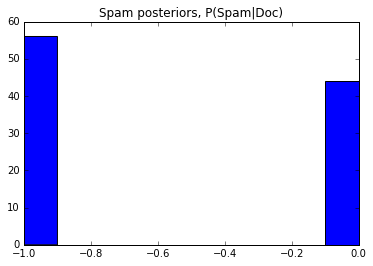

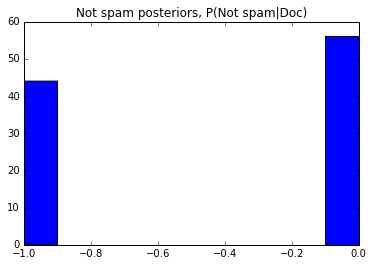

In [71]:
# tell matplotlib not to open a new window
%matplotlib inline

# import the matplotlib library we need for 
# the histogram
import matplotlib.pyplot as plt

# create array to store the probabilities for
# both classes
spam_probs = []
nspam_probs = []

# open the file with the posterior probabilities
with open("Outputs/docpreds","r") as myfile:
    
    # read every line, skipping the first title line
    for line in myfile.readlines()[2:]:
        
        # split the line based on the tabs
        line = line.split("\t")
        
        # append the probabilities
        spam_probs.append(float(line[1]))
        nspam_probs.append(float(line[2]))

# plot the histograms for each class
plt.hist(spam_probs)
plt.title("Spam posteriors, P(Spam|Doc)")
plt.show()
plt.hist(nspam_probs)
plt.title("Not spam posteriors, P(Not spam|Doc)")
plt.show()

***
### HW2.4 Laplace smoothing
Repeat HW2.3 with the following modification: use Laplace plus-one smoothing. Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.

##### Mapper function
We reuse the same mapper function from 2.3.

In [47]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Alex Smith
## Description: mapper code for HW2.3

# import our libraries to use regular expression and 
# read from the system arguments
import sys
import re

# initalize the outputs that we'll be using
email_id = None
word_act = None
spam_ind = None
    
# create a regex that matches alphanumeric characters
wordify = re.compile(r"[\w']+")

# loop through each line in the file
for line in sys.stdin:

    # separate out each line based on the tabs
    line = line.split("\t")
    
    # set the email id and spam indicator fields
    email_id = line[0]
    spam_ind = line[1]

    # grab the text from the body and 
    # subject and concatenate it, if both exist
    if len(line)==4:
        text = line[2] + " " + line[3]
    else:
        text = line[2]

    # convert the text into a list of 
    # words without punctuation
    # also lowercase all the words
    words = wordify.findall(text.lower())
        
    # loop through each word
    for word in words:

        # collect the line that we want to print out
        info = email_id + "\t" + word + "\t" + str(spam_ind)

        # let's print each email id, word, 
        # spam indicator
        # we'll separate each value with a tab character
        print info

Overwriting mapper.py


##### Test the mapper function on the command line

In [48]:
# set the permissions and execute
!chmod +x mapper.py
!cat data/enronemail_1h.txt | ~/w261/mapper.py > testingM.txt
!head testingM.txt

0001.1999-12-10.farmer	christmas	0
0001.1999-12-10.farmer	tree	0
0001.1999-12-10.farmer	farm	0
0001.1999-12-10.farmer	pictures	0
0001.1999-12-10.farmer	na	0
0001.1999-12-10.kaminski	re	0
0001.1999-12-10.kaminski	rankings	0
0001.1999-12-10.kaminski	thank	0
0001.1999-12-10.kaminski	you	0
0001.2000-01-17.beck	leadership	0


##### Reducer function
We re-write the reducer function to add a Laplace smoother. We take out the extra stuff for calculating the number of zero probabilities (no longer needed since we've added the smoother). 

In [49]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Alex Smith
## Description: reducer code for HW2.3

# import the system libraries to read 
# from the input, from the 
# math library import the log function
import sys
from math import log

# create a dictionary to store each email id, 
# spam indciator, list of words of 
# interest, and spam prediction
emails = {}
    
# initalize the summary statistic counts
all_words = 0
all_emails = 0
spam_emails = 0
spam_ewords = 0 # number of words in spam emails

# let's initalize a dictionary that will 
# hold the probabilities for 
# each and every word in the corpus
words_probs = {}

##
##
## gather summary statistics and words for each email
##
##
        
# loop through each line in the file
for line in sys.stdin:

    # split the line by tabs
    line = line.split("\t")

    # pull out my values for each part of the line
    email_id = line[0]
    word_act = line[1]
    spam_ind = int(line[2])

    # let's update the number of words and 
    # the spam words (if it's spam)
    all_words = all_words + 1
    if spam_ind == 1:
        spam_ewords = spam_ewords + 1

    # if we don't already have the word in 
    # our dictionary of words, let's
    # add it and initalize counts of zero
    if word_act not in words_probs:
        words_probs[word_act] = \
        {"spam_count":0,"not_spam_count":0}

    # let's grab the dictionary for the word
    word_dict = words_probs[word_act]

    # let's increment the word counts 
    # for the word
    if spam_ind == 1:
        word_dict['spam_count'] = \
        word_dict['spam_count'] + 1
    else:
        word_dict['not_spam_count'] = \
        word_dict['not_spam_count'] + 1

    # check to see if this email is already 
    # in the dictionary, and if
    # its not already there, initalize it
    if email_id not in emails:

        # create a sub-dictionary within 
        # the email dictionary for each email
        emails[email_id] = \
        {"spam":spam_ind, "words":[]}

        # if it's not already there, 
        # let's also increment the email counter
        # and the spam counter if it's spam
        all_emails = all_emails + 1
        if spam_ind == 1:
            spam_emails = spam_emails + 1

    # let's add the word to our list 
    # of words for this email
    emails[email_id]["words"].append(word_act)

##
##
## build the naive bayes classifier
##
##

# posterior probabilities
prob_spam = float(spam_emails) / float(all_emails)
prob_nspam = 1.0 - prob_spam

# for each word, let's calculate the 
# conditional probability of spam given the word
# and not spam given the word

# let's define our LaPlace smoother 
SMOOTHER = 1.0
VOCAB = float(len(words_probs))

# look at each word
for word in words_probs.keys():
    
    # set the find word that we'll be 
    # calculating the probabilities for
    word = words_probs[word]
    
    # calculate the probability of the word
    word['total'] = word['spam_count'] + \
    word['not_spam_count']
    word['probs'] = float(word['total']) / \
    float(all_words)
    
    # calculate the probability of word 
    # given spam and add the smoother
    word['wordGIVspam'] = \
    float(word['spam_count'] + SMOOTHER) / \
    float(spam_ewords + VOCAB)
    
    # calculate the probability of the word 
    # given not spam and add the smoother
    word['wordGIVnspam'] = \
    float(word['not_spam_count'] + SMOOTHER) / \
    float(all_words-spam_ewords + VOCAB)

# now let's print our model out to the file
# this will be useful because it will make it
# easier to load it in future functions

# set the header
print "Word \tCount \tP(word|Spam) \tP(word|Not Spam)"

# loop through each word
for word in words_probs.keys():

    # set the word name
    word_name = word

    # set the word that we'll be 
    # printing the probabilities for
    word = words_probs[word]

    # set each line as tab delimited
    info = str(word_name) + "\t" +\
    str(word['total']) + "\t" +\
    str(word['wordGIVspam']) + "\t" +\
    str(word['wordGIVnspam'])

    # print each line
    print info   

# print a separating line to split each section
print "*~*~*~*~*"

##
##
## use the classifier to classify each email
##
##      

# create a dictionary that will store the posterior
# probabilities for each email
email_probs = {}

# now let's loop through each email in 
# the dictionary 
for email in emails.keys():
    
    # get the actual classification
    truth = emails[email]["spam"]
    
    # if the email has no words, then set the 
    # prediction based on the posterior
    # probabilities
    if len(emails[email]["words"]) == 0:
        spam_prob = log(prob_spam)
        nspam_prob = log(prob_nspam)
    
    # else if the email has a word, then set 
    # the prediction based on the
    # conditional probability
    else:
        
        # initalize a set of spam and not spam 
        # probabilities that start with the 
        # priors
        spam_prob = log(prob_spam)
        nspam_prob = log(prob_nspam)
        
        # loop through each of the words in 
        # the list of words and 
        # update the spam and not spam probabilities
        for word in emails[email]['words']:
            
            # let's grab the probabilities for spam
            # and not spam
            word_spam_prob = words_probs[word]['wordGIVspam']
            word_nspam_prob = words_probs[word]['wordGIVnspam']
            
            # calculate the probability for each
            # document by adding the log 
            # probabilities for each word
            spam_prob = spam_prob + \
            log(word_spam_prob)
            nspam_prob = nspam_prob + \
            log(word_nspam_prob)
        
        # add the email to the dictionary with its
        # probabilities
        email_probs[email] = [spam_prob,nspam_prob]
        
        # choose the prediction based on the 
        # probabilities
        if(spam_prob > nspam_prob):
            _prediction = 1
        else:
            _prediction = 0
    
    # print the output as the email id, the 
    # actual classification, the prediction
    # as a tab-delimited line
    info = email + "\t" + str(truth) + "\t" + \
    str(_prediction)
    print info

# print a separating line to split each section
print "*~*~*~*~*"
    
##
##
## write a file that has the posterior
## probabilities for each word
##
##

# create the string for the first line
first_line = "ID\tP(spam|doc)\tP(notspam|doc)\n"
print first_line

# loop through each email
for email in email_probs.keys():

    # create the string of probabilities
    info = email + "\t" + \
    str(email_probs[email][0]) + "\t" + \
    str(email_probs[email][1])

    # write the probability to the file
    print info

Overwriting reducer.py


##### Test the reducer on the command line

In [50]:
# set the permissions and execute
!chmod +x reducer.py
!cat testingM.txt | sort -k1,1 | ~/w261/reducer.py > testingR.txt
!head testingR.txt

Word 	Count 	P(word|Spam) 	P(word|Not Spam)
yellow	1	8.27129859388e-05	5.07330931967e-05
four	8	0.000248138957816	0.000202932372787
prefix	1	8.27129859388e-05	5.07330931967e-05
railing	1	8.27129859388e-05	5.07330931967e-05
looking	4	0.000206782464847	5.07330931967e-05
granting	1	8.27129859388e-05	5.07330931967e-05
electricity	1	4.13564929694e-05	0.000101466186393
originality	1	8.27129859388e-05	5.07330931967e-05
homemakers	1	8.27129859388e-05	5.07330931967e-05


##### Set the right permissions and execute the code

In [56]:
# first let's clear our input directory to make
# sure that we're starting off with a clean slate
!hdfs dfs -rm -r /user/cloudera/w261/*

# modifies the permission to make the programs
# executable
!chmod +x ~/w261/mapper.py; chmod +x ~/w261/reducer.py

# put the input data into the hadoop cluster
!hdfs dfs -copyFromLocal /home/cloudera/w261/data/enronemail_1h.txt /user/cloudera/w261/

# make sure that we don't already have this output
!hdfs dfs -rm -r /user/cloudera/w261-output-2-4
!rm -r /home/cloudera/w261/Outputs/Out_2_4

# run the hadoop command
!hadoop jar /usr/lib/hadoop-0.20-mapreduce/contrib/streaming/hadoop-streaming-mr1.jar \
-file /home/cloudera/w261/mapper.py    -mapper /home/cloudera/w261/mapper.py \
-file /home/cloudera/w261/reducer.py   -reducer /home/cloudera/w261/reducer.py \
-input /user/cloudera/w261/* -output /user/cloudera/w261-output-2-4

# copy the output file to the local directory
!hdfs dfs -copyToLocal /user/cloudera/w261-output-2-4/part-00000 /home/cloudera/w261/Outputs/

# rename the file
!mv /home/cloudera/w261/Outputs/part-00000 /home/cloudera/w261/Outputs/Out_2_4

16/05/26 22:21:33 INFO fs.TrashPolicyDefault: Moved: 'hdfs://quickstart.cloudera:8020/user/cloudera/w261/enronemail_1h.txt' to trash at: hdfs://quickstart.cloudera:8020/user/cloudera/.Trash/Current/user/cloudera/w261/enronemail_1h.txt1464326493153
rm: `/user/cloudera/w261-output-2-4': No such file or directory
rm: cannot remove `/home/cloudera/w261/Outputs/Out_2_4': No such file or directory
16/05/26 22:21:41 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/home/cloudera/w261/mapper.py, /home/cloudera/w261/reducer.py] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob9015346952522049383.jar tmpDir=null
16/05/26 22:21:43 INFO client.RMProxy: Connecting to ResourceManager at quickstart.cloudera/10.0.2.15:8032
16/05/26 22:21:43 INFO client.RMProxy: Connecting to ResourceManager at quickstart.cloudera/10.0.2.15:8032
16/05/26 22:21:44 INFO mapred.FileInputFormat: Total input paths to process : 1
16/05/26 22:21:45 IN

##### Prepare our output file
We convert our single output from the reducer to a set of files:
- Wordpreds_smooth: a file that shows the probability of spam and not spam for each word
- Predictions_smooth: a file that records our spam predicition for each document
- Docpreds_smooth: a file that shows the posterior for spam and not spam for each document

In [63]:
# initalize the arrays to hold the information
# for each document
wordpreds = []
predictions = []
docpreds = []

# open the output file
with open ("Outputs/Out_2_4","r") as myfile:
    
    # initalize a counter to keep track of the 
    # file divisions
    count = 0
    
    # loop through every line in the file
    for line in myfile.readlines():
        
        # strip the leading and trailing white space
        line = line.strip()
        
        # we use the counter to keep track of
        # file we write by incrementing it with
        # every file divider
        if line == "*~*~*~*~*":
            count = count + 1
        else:
            
            # add to wordpreds array
            if count == 0:
                wordpreds.append(line)
            
            # add to predicitons array
            if count == 1:
                predictions.append(line)
                
            # add to zeroprobs array
            if count == 2:
                docpreds.append(line)

# write to the files for each array
with open("Outputs/wordspreds_smooth",'w') as myfile:
    for line in wordpreds:
        myfile.write(line.strip()+"\n")
with open("Outputs/predictions_smooth",'w') as myfile:
    for line in predictions:
        myfile.write(line.strip()+"\n")
with open("Outputs/docpreds_smooth",'w') as myfile:
    for line in docpreds:
        myfile.write(line.strip()+"\n")

##### Calculate the training error with smoothing

In [78]:
# import Pretty table to help us compare errors
from prettytable import PrettyTable

# set the error for the model with smoothing
smooth_error = trainingerror("Outputs/predictions_smooth")
print "The training error for our model with smoothing \
is", smooth_error

# create a new table to compare the 
# training errors
pretty = PrettyTable(["Model","Training Error"])
pretty.add_row(["Model without smoothing",nosmooth_error])
pretty.add_row(["Model with smoothing",smooth_error])

# print the table
print pretty

# print explanation
print "My misclassification rate is 0 for both models \
\nbecause the vocabularly between the spam and not spam \
\nemails has so little overlap."

The training error for our model with smoothing is 0.0
+-------------------------+----------------+
|          Model          | Training Error |
+-------------------------+----------------+
| Model without smoothing |      0.0       |
|   Model with smoothing  |      0.0       |
+-------------------------+----------------+
My misclassification rate is 0 for both models 
because the vocabularly between the spam and not spam 
emails has so little overlap.


##### Histogram of posterior probabilities
We create a histogram of the document posterior probabilities for each class.

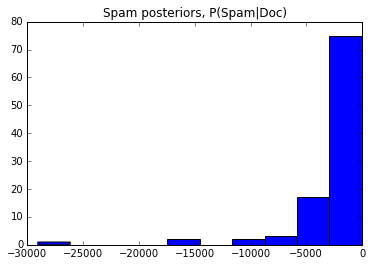

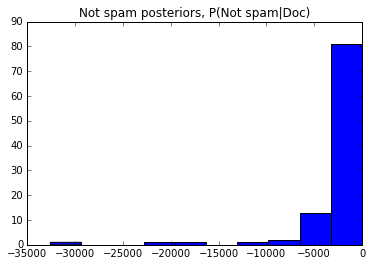

In [79]:
# tell matplotlib not to open a new window
%matplotlib inline

# import the matplotlib library we need for 
# the histogram
import matplotlib.pyplot as plt

# create array to store the probabilities for
# both classes
spam_probs = []
nspam_probs = []

# open the file with the posterior probabilities
with open("Outputs/docpreds_smooth","r") as myfile:
    
    # read every line, skipping the first title line
    for line in myfile.readlines()[2:]:
        
        # split the line based on the tabs
        line = line.split("\t")
        
        # append the probabilities
        spam_probs.append(float(line[1]))
        nspam_probs.append(float(line[2]))

# plot the histograms for each class
plt.hist(spam_probs)
plt.title("Spam posteriors, P(Spam|Doc)")
plt.show()
plt.hist(nspam_probs)
plt.title("Not spam posteriors, P(Not spam|Doc)")
plt.show()

***
### HW2.5. Repeat HW2.4. 
This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset?

##### Mapper function
We repeat our mapper function from 2.4

In [52]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Alex Smith
## Description: mapper code for HW2.5

# import our libraries to use regular expression and 
# read from the system arguments
import sys
import re

# initalize the outputs that we'll be using
email_id = None
word_act = None
spam_ind = None
    
# create a regex that matches alphanumeric characters
wordify = re.compile(r"[\w']+")

# loop through each line in the file
for line in sys.stdin:

    # separate out each line based on the tabs
    line = line.split("\t")
    
    # set the email id and spam indicator fields
    email_id = line[0]
    spam_ind = line[1]

    # grab the text from the body and 
    # subject and concatenate it, if both exist
    if len(line)==4:
        text = line[2] + " " + line[3]
    else:
        text = line[2]

    # convert the text into a list of 
    # words without punctuation
    # also lowercase all the words
    words = wordify.findall(text.lower())
        
    # loop through each word
    for word in words:

        # collect the line that we want to print out
        info = email_id + "\t" + word + "\t" + str(spam_ind)

        # let's print each email id, word, 
        # spam indicator
        # we'll separate each value with a tab character
        print info

Overwriting mapper.py


##### Test the mapper on the command line

In [53]:
# set the permissions and execute
!chmod +x mapper.py
!cat data/enronemail_1h.txt | ~/w261/mapper.py > testingM.txt
!head testingM.txt

0001.1999-12-10.farmer	christmas	0
0001.1999-12-10.farmer	tree	0
0001.1999-12-10.farmer	farm	0
0001.1999-12-10.farmer	pictures	0
0001.1999-12-10.farmer	na	0
0001.1999-12-10.kaminski	re	0
0001.1999-12-10.kaminski	rankings	0
0001.1999-12-10.kaminski	thank	0
0001.1999-12-10.kaminski	you	0
0001.2000-01-17.beck	leadership	0


##### Reducer function
We modify the reducer function to ignore words that occur less than 3 times.

In [54]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Alex Smith
## Description: reducer code for HW2.5

# import the system libraries to read 
# from the input, from the 
# math library import the log function
import sys
from math import log

# create a dictionary to store each email id, 
# spam indciator, list of words of 
# interest, and spam prediction
emails = {}
    
# initalize the summary statistic counts
all_words = 0
all_emails = 0
spam_emails = 0
spam_ewords = 0 # number of words in spam emails

# let's initalize a dictionary that will 
# hold the probabilities for 
# each and every word in the corpus
words_probs = {}

##
##
## gather summary statistics and words for each email
##
##
        
# loop through each line in the file
for line in sys.stdin:

    # split the line by tabs
    line = line.split("\t")

    # pull out my values for each part of the line
    email_id = line[0]
    word_act = line[1]
    spam_ind = int(line[2])

    # let's update the number of words and 
    # the spam words (if it's spam)
    all_words = all_words + 1
    if spam_ind == 1:
        spam_ewords = spam_ewords + 1

    # if we don't already have the word in 
    # our dictionary of words, let's
    # add it and initalize counts of zero
    if word_act not in words_probs:
        words_probs[word_act] = \
        {"spam_count":0,"not_spam_count":0}

    # let's grab the dictionary for the word
    word_dict = words_probs[word_act]

    # let's increment the word counts 
    # for the word
    if spam_ind == 1:
        word_dict['spam_count'] = \
        word_dict['spam_count'] + 1
    else:
        word_dict['not_spam_count'] = \
        word_dict['not_spam_count'] + 1

    # check to see if this email is already 
    # in the dictionary, and if
    # its not already there, initalize it
    if email_id not in emails:

        # create a sub-dictionary within 
        # the email dictionary for each email
        emails[email_id] = \
        {"spam":spam_ind, "words":[]}

        # if it's not already there, 
        # let's also increment the email counter
        # and the spam counter if it's spam
        all_emails = all_emails + 1
        if spam_ind == 1:
            spam_emails = spam_emails + 1

##
##
## gather the information for each email
##
##

# set the minimum count for classification
COUNT = 3

# loop through each file in the list of count files
for line in sys.stdin:

    # split the line by tabs
    line = line.split("\t")

    # pull out my values for each part 
    # of the line
    email_id = line[0]
    word_act = line[1]

    # check to make sure the word occurs
    # at least 3 times
    word_count = \
    words_probs[word_act]['spam_count']+\
    words_probs[word_act]['nspam_count']

    # if the word appears at least as many
    # times as we have requested
    if word_count >= COUNT:

        # let's add the word to our list 
        # of words for this email
        emails[email_id]["words"].append(word_act)    

##
##
## build the naive bayes classifier
##
##

# posterior probabilities
prob_spam = float(spam_emails) / float(all_emails)
prob_nspam = 1.0 - prob_spam

# for each word, let's calculate the 
# conditional probability of spam given the word
# and not spam given the word

# let's define our LaPlace smoother 
SMOOTHER = 1.0
VOCAB = float(len(words_probs))

# look at each word
for word in words_probs.keys():
    
    # set the find word that we'll be 
    # calculating the probabilities for
    word = words_probs[word]
    
    # calculate the probability of the word
    word['total'] = word['spam_count'] + \
    word['not_spam_count']
    word['probs'] = float(word['total']) / \
    float(all_words)
    
    # calculate the probability of word 
    # given spam and add the smoother
    word['wordGIVspam'] = \
    float(word['spam_count'] + SMOOTHER) / \
    float(spam_ewords + VOCAB)
    
    # calculate the probability of the word 
    # given not spam and add the smoother
    word['wordGIVnspam'] = \
    float(word['not_spam_count'] + SMOOTHER) / \
    float(all_words-spam_ewords + VOCAB)

# now let's print our model out to the file
# this will be useful because it will make it
# easier to load it in future functions

# set the header
print "Word \tCount \tP(word|Spam) \tP(word|Not Spam)"

# loop through each word
for word in words_probs.keys():

    # set the word name
    word_name = word

    # set the word that we'll be 
    # printing the probabilities for
    word = words_probs[word]

    # set each line as tab delimited
    info = str(word_name) + "\t" +\
    str(word['total']) + "\t" +\
    str(word['wordGIVspam']) + "\t" +\
    str(word['wordGIVnspam'])

    # print each line
    print info   

# print a separating line to split each section
print "*~*~*~*~*"

##
##
## use the classifier to classify each email
##
##      

# create a dictionary that will store the posterior
# probabilities for each email
email_probs = {}

# now let's loop through each email in 
# the dictionary 
for email in emails.keys():
    
    # get the actual classification
    truth = emails[email]["spam"]
    
    # if the email has no words, then set the 
    # prediction based on the posterior
    # probabilities
    if len(emails[email]["words"]) == 0:
        spam_prob = log(prob_spam)
        nspam_prob = log(prob_nspam)
    
    # else if the email has a word, then set 
    # the prediction based on the
    # conditional probability
    else:
        
        # initalize a set of spam and not spam 
        # probabilities that start with the 
        # priors
        spam_prob = log(prob_spam)
        nspam_prob = log(prob_nspam)
        
        # loop through each of the words in 
        # the list of words and 
        # update the spam and not spam probabilities
        for word in emails[email]['words']:
            
            # let's grab the probabilities for spam
            # and not spam
            word_spam_prob = words_probs[word]['wordGIVspam']
            word_nspam_prob = words_probs[word]['wordGIVnspam']
            
            # calculate the probability for each
            # document by adding the log 
            # probabilities for each word
            spam_prob = spam_prob + \
            log(word_spam_prob)
            nspam_prob = nspam_prob + \
            log(word_nspam_prob)
        
        # add the email to the dictionary with its
        # probabilities
        email_probs[email] = [spam_prob,nspam_prob]
        
    # choose the prediction based on the 
    # probabilities
    if(spam_prob > nspam_prob):
        _prediction = 1
    else:
        _prediction = 0
    
    # print the output as the email id, the 
    # actual classification, the prediction
    # as a tab-delimited line
    info = email + "\t" + str(truth) + "\t" + \
    str(_prediction)
    print info

Overwriting reducer.py


##### Test the reducer on the command line

In [55]:
# set the permissions and execute
!chmod +x reducer.py
!cat testingM.txt | sort -k1,1 | ~/w261/reducer.py > testingR.txt
!head testingR.txt

Word 	Count 	P(word|Spam) 	P(word|Not Spam)
yellow	1	8.27129859388e-05	5.07330931967e-05
four	8	0.000248138957816	0.000202932372787
prefix	1	8.27129859388e-05	5.07330931967e-05
railing	1	8.27129859388e-05	5.07330931967e-05
looking	4	0.000206782464847	5.07330931967e-05
granting	1	8.27129859388e-05	5.07330931967e-05
electricity	1	4.13564929694e-05	0.000101466186393
originality	1	8.27129859388e-05	5.07330931967e-05
homemakers	1	8.27129859388e-05	5.07330931967e-05


##### Set the right permissions and execute the code

In [83]:
# first let's clear our input directory to make
# sure that we're starting off with a clean slate
!hdfs dfs -rm -r /user/cloudera/w261/*

# modifies the permission to make the programs
# executable
!chmod +x ~/w261/mapper.py; chmod +x ~/w261/reducer.py

# put the input data into the hadoop cluster
!hdfs dfs -copyFromLocal /home/cloudera/w261/data/enronemail_1h.txt /user/cloudera/w261/

# make sure that we don't already have this output
!hdfs dfs -rm -r /user/cloudera/w261-output-2-5
!rm -r /home/cloudera/w261/Outputs/Out_2_5

# run the hadoop command
!hadoop jar /usr/lib/hadoop-0.20-mapreduce/contrib/streaming/hadoop-streaming-mr1.jar \
-file /home/cloudera/w261/mapper.py    -mapper /home/cloudera/w261/mapper.py \
-file /home/cloudera/w261/reducer.py   -reducer /home/cloudera/w261/reducer.py \
-input /user/cloudera/w261/* -output /user/cloudera/w261-output-2-5

# copy the output file to the local directory
!hdfs dfs -copyToLocal /user/cloudera/w261-output-2-5/part-00000 /home/cloudera/w261/Outputs/

# rename the file
!mv /home/cloudera/w261/Outputs/part-00000 /home/cloudera/w261/Outputs/Out_2_5

16/05/26 22:49:39 INFO fs.TrashPolicyDefault: Moved: 'hdfs://quickstart.cloudera:8020/user/cloudera/w261/enronemail_1h.txt' to trash at: hdfs://quickstart.cloudera:8020/user/cloudera/.Trash/Current/user/cloudera/w261/enronemail_1h.txt1464328179074
rm: `/user/cloudera/w261-output-2-5': No such file or directory
rm: cannot remove `/home/cloudera/w261/Outputs/Out_2_5': No such file or directory
16/05/26 22:49:47 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/home/cloudera/w261/mapper.py, /home/cloudera/w261/reducer.py] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob5648932769200571239.jar tmpDir=null
16/05/26 22:49:49 INFO client.RMProxy: Connecting to ResourceManager at quickstart.cloudera/10.0.2.15:8032
16/05/26 22:49:50 INFO client.RMProxy: Connecting to ResourceManager at quickstart.cloudera/10.0.2.15:8032
16/05/26 22:49:51 INFO mapred.FileInputFormat: Total input paths to process : 1
16/05/26 22:49:51 IN

##### Prepare the output file
We split our output file into:
- Predictions_three: a file that shows our predictions for each model
- Wordspreds_three: a file that shows our probabilities for each word

In [84]:
# initalize the arrays to hold the information
# for each document
wordpreds = []
predictions = []

# open the output file
with open ("Outputs/Out_2_5","r") as myfile:
    
    # initalize a counter to keep track of the 
    # file divisions
    count = 0
    
    # loop through every line in the file
    for line in myfile.readlines():
        
        # strip the leading and trailing white space
        line = line.strip()
        
        # we use the counter to keep track of
        # file we write by incrementing it with
        # every file divider
        if line == "*~*~*~*~*":
            count = count + 1
        else:
            
            # add to wordpreds array
            if count == 0:
                wordpreds.append(line)
            
            # add to predicitons array
            if count == 1:
                predictions.append(line)

# write to the files for each array
with open("Outputs/wordspreds_three",'w') as myfile:
    for line in wordpreds:
        myfile.write(line.strip()+"\n")
with open("Outputs/predictions_three",'w') as myfile:
    for line in predictions:
        myfile.write(line.strip()+"\n")

##### Compare the training errors between the models

In [85]:
# import Pretty table to help us compare errors
from prettytable import PrettyTable

# set the error for the model with smoothing
three_error = trainingerror("Outputs/predictions_three")
print "The training error for our model that uses \
words with a minimum count of 3 is", three_error

# create a new table to compare the 
# training errors
pretty = PrettyTable(["Model","Training Error"])
pretty.add_row(["Model without smoothing",nosmooth_error])
pretty.add_row(["Model with smoothing",smooth_error])
pretty.add_row(["Model with 3 count minimum",three_error])

# print the table
print pretty

The training error for our model that uses words with a minimum count of 3 is 0.44
+----------------------------+----------------+
|           Model            | Training Error |
+----------------------------+----------------+
|  Model without smoothing   |      0.0       |
|    Model with smoothing    |      0.0       |
| Model with 3 count minimum |      0.44      |
+----------------------------+----------------+


When we only count words that appeared at least 3 times, we lose a lot of information. When we used every word, we were able to identify spam and not spam emails more easily because their vocabulary was non-overlapping. Now, we've reduced the vocabularly of the emails to only overlapping words. In essence, our model is only predicting not spam for all emails.

***
### HW2.6 Benchmark 
*Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm. It always a good idea to benchmark your solutions against publicly available libraries such as SciKit-Learn, The Machine Learning toolkit available in Python. In this exercise, we benchmark ourselves against the SciKit-Learn implementation of multinomial Naive Bayes.  For more information on this implementation see: http://scikit-learn.org/stable/modules/naive_bayes.html more. In this exercise, please complete the following:* <br>
- *Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)*
- *Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error*
- *Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn*

##### Data preparation for Sklearn
Before putting the data through the sklearn algorithms, we have to prepare it. We do this by using the Sklearn's countvectorizers to transform the data into a bag of words. **Important note: we borrow much of this code from HW1.**

In [87]:
# import the count vectorizer function from the 
# appropriate Sklearn library and import numpy to reshape
# the labels array into a 100 x 1 array
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# create arrays to hold the data
email_ids = []
train_labels = []
email_text = []

# begin by opening the file
with open("data/enronemail_1h.txt", "r") as myfile:
    
    # loop through each line
    for record in myfile.readlines():
        
        # split each line based on the tabs
        record = record.split("\t")
        
        # generate the text as a combination 
        # of the subject and body, if the email
        # has both
        if len(record) == 4:
            text = record[2] + " " + record[3]
        
        # otherwise take the subject or body, 
        # whichever is present
        else:
            text = record[2]
        
        # add to the email_ids, to the labels, 
        # and to the email text
        email_ids.append(record[0])
        train_labels.append(record[1])
        email_text.append(text)
        
# genearate a bag of words on the email texts 
# by using count vectorizer
bag = CountVectorizer()
train_data = bag.fit_transform(email_text)

# convert email labels into a numpy array of size 100x1
train_labels = np.array(train_labels).reshape(-1)

# to verify that we've got the right thing, 
# let's print out the shape
# of our training data and training labels. 
# it should be 100 rows 
# have a column for every word
print "Our bag of words has a shape of:",train_data.shape
print "Our traiing labels have a shape of:", train_labels.shape

Our bag of words has a shape of: (100, 5375)
Our traiing labels have a shape of: (100,)


##### Outputing SKLearn Findings
We create a function that will output the results from running SKLearn's algorithms. 

In [88]:
def outputSK(filename,record_ids,truths,predictions):
    """Takes three arrays (record id, truth, 
    prediction) and a file name and arranges 
    them as a tab delimited file with columns: 
    record id, truth, and prediction and
    outputs the file with specified file name"""
    
    # open the file as write-able
    with open(filename, "w") as myfile:
        
        # loop through every record ids, truth, 
        # and prediction
        for index,record in enumerate(record_ids):
            
            # create the line that has the information 
            # we'll write to the file
            new_line = record_ids[index] + "\t" + \
            truths[index] + "\t" + \
            predictions[index] + "\n"
            
            # write the line to the file
            myfile.write(new_line)

##### SKLearn's Multinomial Naive Bayes Algorithm
We use SKLearn's multinomial naive bayes algorithm on our email data to generate predictions of spam or not spam. We then use our output function to save the file. 

In [90]:
# import the multinomial naive bayes algorithm
from sklearn.naive_bayes import MultinomialNB

# create and train the model on our data
sk_multinomial = MultinomialNB()
sk_multinomial.fit(train_data,train_labels)

# use our model to predict the training data
sk_predictions = sk_multinomial.predict(train_data)

# output the results to a file that we 
# can use for comparison
outputSK("Outputs/sk_multinomial.txt",email_ids,\
         train_labels,sk_predictions)

print "Check out the output file \
'sk_multinomial.txt' \nto see the results from \
the SK Learn\n Multinomial Naive Bayes algorithm."

Check out the output file 'sk_multinomial.txt' 
to see the results from the SK Learn
 Multinomial Naive Bayes algorithm.


##### Reporting the training error
Now let's report the training error across the 4 models (our MapReduce without smoothing, our MapReduce with smoothing, our MapReduce only counting 3+ words, and SKLearn's basic Naive Bayes). We use the training error function we defined above.

In [93]:
# import the python library pretty table; 
# this wil help us print out the comparison 
# very clearly
from prettytable import PrettyTable

# get the training errors
sk_multi_error = trainingerror("Outputs/sk_multinomial.txt")


# create the pretty table and add a row for each model
pretty = PrettyTable(["Model","Training Error Rate"])
pretty.add_row(["My MapReduce without smoothing", nosmooth_error])
pretty.add_row(["My MapReduce with smoothing", smooth_error])
pretty.add_row(["Model with 3 count minimum",three_error])
pretty.add_row(["SKLearn's Multinomial Model", sk_multi_error])

# print out the table
print pretty

+--------------------------------+---------------------+
|             Model              | Training Error Rate |
+--------------------------------+---------------------+
| My MapReduce without smoothing |         0.0         |
|  My MapReduce with smoothing   |         0.0         |
|   Model with 3 count minimum   |         0.44        |
|  SKLearn's Multinomial Model   |         0.0         |
+--------------------------------+---------------------+


Other than the model with the 3 count minimum, our models and the SKLearn model achieved the same accuracy. This likely due to the fact that the vocabularlies for spam and not spam emails were fairly distinct. Our model with the 3 count minimum suffered from eliminating so much information and making the vocabularies more similar. We should also remember that we are reporting only training error here because we have only tested our models on our training data. 